# Network analysis for coauthors - modularity

This looks at modularity of the main subgraph.

In [1]:
%load_ext autoreload
%autoreload 2

from src.util import load_coauthor_nx, ddir, fn_nodes, fn_statoids, fn_spp

import community
import networkx as nx
from operator import itemgetter
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import skbio.diversity.alpha as b
import math
import random

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn import preprocessing
import numpy as np

In [2]:
# Params
seed = 2021
random.seed(seed)

# Load graph
(G, nodes) = load_coauthor_nx() # abstracted into src

N nodes 391 ; N not nodes: 360
Proportion who did not coauthor 47.9 %

Name: 
Type: Graph
Number of nodes: 391
Number of edges: 510
Average degree:   2.6087


## Communities

In [3]:
# Read data
nodes_df = pd.read_csv(fn_nodes)
statoids = pd.read_csv(fn_statoids)
statoids = area_dict = dict(zip(statoids.DL, statoids.Country))

spp = pd.read_csv(fn_spp)[["idx", "full.name.of.describer"]]
spp = spp[spp.duplicated(subset="idx", keep=False)]             # keep only those with >1 authors

/home/ejysoh/miniconda3/envs/msc/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (22,30,60,61,65,86,89,106,117) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Add module information
communities = community.best_partition(G, random_state=seed)  # https://python-louvain.readthedocs.io/en/latest/api.html
nx.set_node_attributes(G, communities, 'modularity')

In [5]:
G.nodes["Michael Scott Engel"]

{'country_of_residence': 'US',
 'ns_spp_n': 224,
 'degree': 31,
 'betweenness': 0.14524584527847992,
 'eigenvector': 0.4588865861998399,
 'modularity': 8}

In [6]:
# Function to get highest eigenvector centrality from each module
# module_number refers to the original module number
def get_highest_eigen_in_module(module_number):

    module = [n for n in G.nodes() if G.nodes[n]['modularity'] == module_number]

    print("Number of nodes: ", len(set(module)), " in module ", module_number, "\n")

    # Then create a dictionary of the eigenvector centralities of those nodes
    module_eigenvector = {n:G.nodes[n]['eigenvector'] for n in module}

    # Then sort that dictionary and print the first 5 results
    module_sorted_by_eigenvector = sorted(module_eigenvector.items(), key=itemgetter(1), reverse=True)
    print("Modularity Sorted by Eigenvector Centrality:")
    for node in module_sorted_by_eigenvector[:10]:
        print(node[0], "| ", node[1], " | ", G.nodes[node[0]]['country_of_residence'])
        
    print("\n\n")

In [7]:
# Test the function on module 0
get_highest_eigen_in_module(0)

Number of nodes:  15  in module  0 

Modularity Sorted by Eigenvector Centrality:
Maximilian Schwarz |  0.08084146449549443  |  AU
Fritz Josef [Friedrich] Gusenleitner |  0.01635333120213761  |  AU
Karl Mazzucco |  0.012015231943082728  |  AU
Esther Ockermüller |  0.011209840199713222  |  AU
Jan Smit |  0.011209840199713222  |  NL
Klaus Standfuss |  0.00984467927893155  |  GA
Timofey Victorovich Levchenko |  0.00984467927893155  |  RS
Erwin Scheuchl |  0.006744632643034571  |  GM
Ardeshir Ariana |  0.0062729046007867755  |  JA
Gerald Hölzler |  0.0014633793955146125  |  AU





In [8]:
# Create dictionary of module (key) and authors (value)

modularity = {}                            # Create a new, empty dictionary

for k, v in communities.items():           # Loop through the community dictionary
    if v not in modularity:
        modularity[v] = [k]                # Add a new key for a modularity class the code hasn't seen before
    else:
        modularity[v].append(k)            # Append a name to the list for a modularity class the code has already seen


# Create counter of countries (value) for each module (key)

countries = {}
counter = 0
for k, v in modularity.items():            # Loop through the new dictionary
    counter = counter + len(v)
    country_li = []
    for i in range(0, len(v)):
        country = nodes_df[nodes_df['full.name.of.describer'] == v[i]]['residence.country.describer'].values[0]
        country = str.split(country, "; ")
        country_li = country_li + [country[0]]
    countries[k] = Counter(country_li)

print("\n In total, ", counter, " authors/ nodes.")


 In total,  391  authors/ nodes.


In [9]:
# Count number of modules

print(len(modularity), " modules")    # number of modules

59  modules


In [10]:
# Get a dataframe of module (index) and subgraph (0 column)

subgraphs = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

def get_subgraph(node_name):
    subgraph_idx = -1
    
    for i in range(0, len(subgraphs)):
        if (node_name in list(subgraphs[i])):
            subgraph_idx = i
    
    return subgraph_idx
          
community_subgraph = pd.DataFrame.from_dict({key:get_subgraph(value[0]) for (key,value) in modularity.items()}, orient='index')

In [11]:
# Get number of species for each module as a dataframe

N_species = {}

for i, sg in enumerate(modularity.items()):
    spp_li = []
    
    for auth in sg[1]:
        spp_li = spp_li + list(spp[spp['full.name.of.describer']==auth]['idx'].values)
        
    N_species[i] = len(set(spp_li))
    
N_species = pd.DataFrame.from_dict(N_species, orient="index")
N_species.columns = ["N_species"]

In [12]:
# Convert dictionary countries to pandas.DataFrame countries_df
countries_df = pd.DataFrame.from_dict(countries, orient='index')
cols = list(countries_df.columns.values) 

# Shift column [unknown] to end
cols.pop(cols.index('[unknown]'))
cols_rearranged = cols + ['[unknown]']
countries_df = countries_df[cols_rearranged]

# Sort by index
countries_df = countries_df.sort_index()

In [13]:
# Get number of authors and countries as a dataframe for each module

countries_summary1 = countries_df.sum(axis=1)   # count number of authors in each module
countries_summary2 = countries_df.count(axis=1) # count number of countries in each module

# Combine all dataframes (N authors, N countries, Subgraph, N species)

countries_summary = pd.concat([countries_summary1, countries_summary2], axis=1) 
countries_summary = countries_summary.merge(community_subgraph, "outer", left_index=True, right_index=True)
countries_summary = countries_summary.merge(N_species, "outer", left_index=True, right_index=True)
countries_summary.columns = ['N_authors', 'N_countries', 'Subgraph_id', 'N_species']
countries_summary.index.names = ['Modules']

# Create a new column called "idx" (which will be the way the dataframe is sorted later for labels)

# It is sorted by Subgraph_id and N_authors
countries_summary = countries_summary.sort_values(['Subgraph_id', 'N_authors'], ascending=[True,  False])
countries_summary['idx'] = range(0, len(countries_summary))
# Create label
countries['lab'] = ' [' + countries_summary['N_authors'].astype(int).astype(str) + ',' +\
    countries_summary['N_countries'].astype(int).astype(str) + "," +\
    countries_summary['N_species'].astype(int).astype(str) + '] ' +\
    "id" + countries_summary.idx.astype(str).str.pad(2, "left", "0") + " / " +\
    "S" + countries_summary['Subgraph_id'].astype(str).str.pad(2, "left", "0")

# Sort by index and save idx
countries_summary = countries_summary.sort_index()
idx = countries_summary.idx.values
countries_summary = countries_summary.sort_values('idx')

In [14]:
# Summary stats for ALL subgraphs
countries_summary.agg({
    'N_authors': ['median', 'min', 'max'],
    'N_countries': ['median', 'min', 'max']
})

,N_authors,N_countries
median,2.0,1.0
min,2.0,1.0
max,49.0,12.0


In [15]:
# Summary stats for subgraph 1
countries_summary.groupby('Subgraph_id')\
                 .agg({'N_authors': ['median', 'min', 'max'],
                       'N_countries': ['median', 'min', 'max', 'count']})\
                 .iloc[0] # for subgraph 1

N_authors    median    14.5
             min        5.0
             max       49.0
N_countries  median     4.5
             min        1.0
             max       12.0
             count     14.0
Name: 0, dtype: float64

All of the subgraphs only have one cluster, but the largest one has 12 clusters.

In [16]:
# Get proportions
countries_prop = countries_df.apply(lambda r: round(r/r.sum()*100, 1), axis=1)
countries_prop.index = idx
countries_prop = countries_prop.sort_index()
countries_prop.index = countries['lab']

In [17]:
# Get full country name from abbreviated form
def parse_countries(country):
    if country == "[unknown]":
        return country
    else:
        return statoids[country]

countries_prop.columns = [parse_countries(x) for x in countries_prop.columns]
# countries_prop.columns = countries_prop.columns + " [" + countries_prop.count().astype(str) + "]"

In [18]:
countries_prop.columns

Index(['Algeria', 'Austria', 'Gambia', 'Germany', 'Israel', 'Japan',
       'Netherlands', 'Russian Federation', 'Turkey', 'Argentina', 'Chile',
       'Spain', 'United States of America', 'Australia', 'Belgium', 'Canada',
       'Cameroon', 'Ethiopia', 'France', 'New Zealand', 'South Africa',
       'Thailand', 'China', 'Indonesia', 'Norway', 'Sweden', 'Taiwan',
       'Brazil', 'Colombia', 'Denmark', 'Czech Republic', 'Mexico', 'Peru',
       'Saudi Arabia', 'United Kingdom', 'Costa Rica', 'India', 'Pakistan',
       'Panama', 'Italy', 'Switzerland', 'Paraguay', 'Cuba', 'Kenya',
       'Portugal', 'Ukraine', 'Iran', 'Korea, South', 'Venezuela',
       '[unknown]'],
      dtype='object')

[Text(0.5, 96.0, '\nProportion of country from each module (%)'),
 Text(114.0, 0.5, 'Countries')]

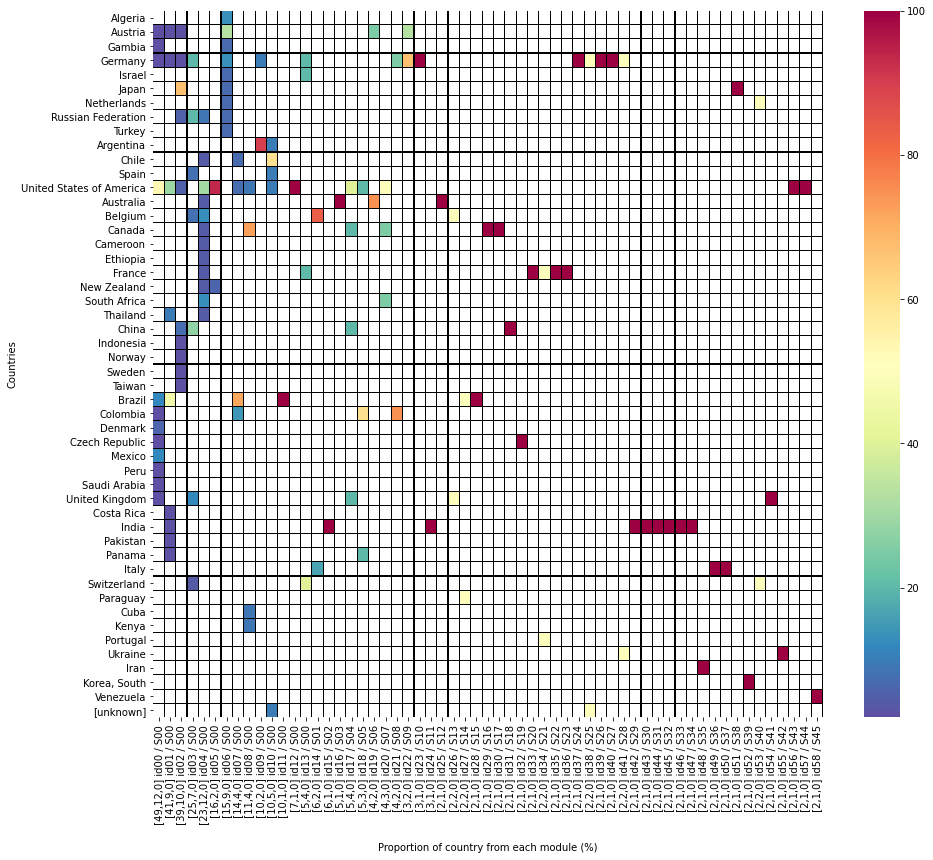

In [19]:
# Plot graph
countries_prop_t = countries_prop.transpose(copy=True)
countries_prop_t[countries_prop_t.columns] = countries_prop_t[countries_prop_t.columns].replace({0: float('nan')})
plt.figure(figsize=(15, 13))
ax = sns.heatmap(countries_prop_t, cmap=plt.get_cmap("Spectral_r"), linecolor="k", linewidths=0.1)
ax.set(xlabel='\nProportion of country from each module (%)', ylabel='Countries')

In [20]:
countries_prop.iloc[3][countries_prop.iloc[3].notnull()]

Germany               20.0
Russian Federation    20.0
Spain                  8.0
Belgium                8.0
China                 28.0
United Kingdom        12.0
Switzerland            4.0
Name:  [25,7,0] id03 / S00, dtype: float64

In [21]:
# Calculate diversity indices

indices_simpsons = []
indices_shannon = []

for i, idx in enumerate(countries_prop.index):
    country_counts = [x for x in countries_prop.iloc[i].values if not math.isnan(x)]
    
    # indices = countries_prop.iloc[i][countries_prop.iloc[i].notna()].values
    indices_simpsons =  indices_simpsons + [b.simpson(country_counts)]
    indices_shannon =  indices_shannon + [b.shannon(country_counts)]

countries_summary['simpson'] = indices_simpsons
countries_summary['shannon'] = indices_shannon

In [22]:
countries_summary_original = countries_summary.copy(deep=True)
countries_summary_original

,N_authors,N_countries,Subgraph_id,N_species,idx,simpson,shannon
Modules,,,,,,,
8,49.0,12,0,0,0,0.678785,2.378378
9,41.0,9,0,0,1,0.685465,2.137902
7,39.0,10,0,0,2,0.541759,1.932851
12,25.0,7,0,0,3,0.812800,2.578830
6,23.0,12,0,0,4,0.849926,3.164224
52,16.0,2,0,0,5,0.116312,0.335334
0,15.0,9,0,0,6,0.827145,2.868719
15,14.0,4,0,0,7,0.458591,1.289978
20,11.0,4,0,0,8,0.446628,1.278431


In [23]:
# countries_summary = countries_summary_original.copy(deep=True)

In [24]:
# Scale values by min max for PCA

cols = ['N_authors', 'N_countries', 'N_species', 'simpson']
x = countries_summary[cols].values #returns a numpy array
scaler = preprocessing.StandardScaler()
countries_summary_scaled = pd.DataFrame(scaler.fit_transform(x))

In [25]:
# Perform PCA

pca = PCA(n_components=2, svd_solver='full')
pca.fit(countries_summary_scaled)
pca.values = pca.transform(countries_summary_scaled)
pca.values = pd.DataFrame(pca.values, columns=['PC1', 'PC2'])

var = pca.explained_variance_ratio_
countries_summary = countries_summary.reset_index().merge(pca.values, left_index=True, right_index=True)

In [26]:
# Perform DBSCAN
cluster = KMeans(n_clusters=5, random_state=22).fit(countries_summary[['PC1', 'PC2']].values)
countries_summary['KMeans group'] = cluster.labels_ + 1
countries_summary.loc[countries_summary['KMeans group'] == 0, 'KMeans group'] = "Ungrouped"

In [27]:
countries_summary

,Modules,N_authors,N_countries,Subgraph_id,N_species,idx,simpson,shannon,PC1,PC2,KMeans group
0,8,49.0,12,0,0,0,0.678785,2.378378,5.486760,1.817894,4
1,9,41.0,9,0,0,1,0.685465,2.137902,4.349760,1.181307,4
2,7,39.0,10,0,0,2,0.541759,1.932851,4.194444,1.479296,4
3,12,25.0,7,0,0,3,0.812800,2.578830,3.202245,-0.248744,3
4,6,23.0,12,0,0,4,0.849926,3.164224,4.298027,-0.287675,3
5,52,16.0,2,0,0,5,0.116312,0.335334,0.239617,0.869971,2
6,0,15.0,9,0,0,6,0.827145,2.868719,3.106116,-0.844925,3
7,15,14.0,4,0,0,7,0.458591,1.289978,1.218627,-0.103253,5
8,20,11.0,4,0,0,8,0.446628,1.278431,1.022363,-0.260811,5
9,1,10.0,2,0,0,9,0.180000,0.468996,0.010389,0.318918,2


/home/ejysoh/miniconda3/envs/msc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


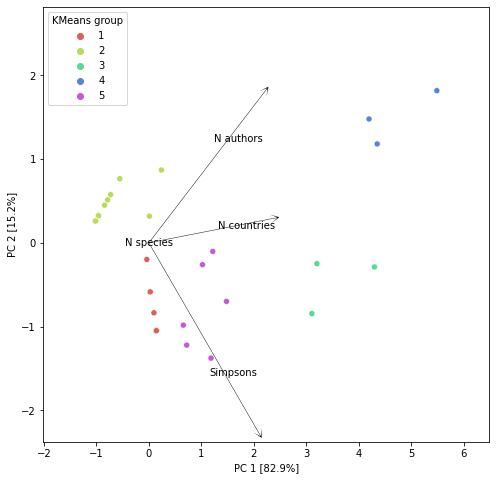

In [28]:
# Get the PCA components (loadings)
PCs = pca.components_

# Use quiver to generate the basic plot
fig = plt.figure(figsize=(8, 8))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:]*4, PCs[1,:]*3, 
           angles='xy', scale_units='xy', scale=1, 
           width = 0.001, headwidth = 20, headlength = 20)

# Add labels based on feature names (here just numbers)
feature_names = ['N authors', 'N countries', 'N species', 'Simpsons']
for i,j,z in zip(PCs[1,:]*2, PCs[0,:]*3, feature_names):
    plt.text(j, i, z, ha='center', va='center')

# # Add unit circle
# circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
# plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
# plt.axis('equal')
plt.xlim([countries_summary['PC1'].min()-1, countries_summary['PC1'].max()+1])
plt.ylim([countries_summary['PC2'].min()-1, countries_summary['PC2'].max()+1])

# Plot value
n_colours = len(countries_summary['KMeans group'].unique())
sns.scatterplot(countries_summary['PC1'], countries_summary['PC2'],  
                hue=countries_summary['KMeans group'], palette=sns.color_palette("hls", n_colours), legend="brief")

# Label axes
xlab = "PC 1 [" + str(round(var[0]*100, 1)) + "%]"
plt.xlabel(xlab)
ylab = "PC 2 [" + str(round(var[1]*100, 1)) + "%]"
plt.ylabel(ylab)

plt.show()

In [29]:
countries_summary.agg({'N_authors': ['count', 'median', 'min', 'max'],
                       'N_countries': ['median', 'min', 'max'],
                       'N_species': ['median', 'min', 'max'],
                       'simpson': ['median', 'min', 'max']})

,N_authors,N_countries,N_species,simpson
count,59.0,NaN,NaN,NaN
median,2.0,1.0,0.0,0.000000
min,2.0,1.0,0.0,0.000000
max,49.0,12.0,0.0,0.849926


In [30]:
# Summary stats for subgraph 1
countries_summary.groupby('KMeans group')\
                 .agg({'N_authors': ['count', 'median', 'min', 'max'],
                       'N_countries': ['median', 'min', 'max'],
                       'N_species': ['median', 'min', 'max'],
                       'simpson': ['median', 'min', 'max']})

# group 1: high authors, low countries, high species, low simpsons = not international, contribute to many species
# group 2: mid authors, mid countries, mid species, high simpsons = international, mid-sized
# group 3: low authors, low countries, low species, mid simpsons = international, small-sized
# group 4: high authors, high countries, high species, high simpsons = international, big-sized
# group 5: low authors, low countries, low species, low simpsons = not international, contribute to few species

N_authors                    N_countries         N_species      \
                 count median   min   max      median min max    median min   
KMeans group                                                                  
1                   10    2.0   2.0   6.0           2   2   2         0   0   
2                   36    2.0   2.0  16.0           1   1   2         0   0   
3                    3   23.0  15.0  25.0           9   7  12         0   0   
4                    3   41.0  39.0  49.0          10   9  12         0   0   
5                    7    5.0   4.0  14.0           4   3   5         0   0   

                   simpson                      
             max    median       min       max  
KMeans group                                    
1              0  0.500000  0.278222  0.500000  
2              0  0.000000  0.000000  0.180000  
3              0  0.827145  0.812800  0.849926  
4              0  0.678785  0.541759  0.685465  
5              0  0.600000  0.446628  0.720000

In [31]:
countries_summary.iloc[3]

Modules               12
N_authors           25.0
N_countries            7
Subgraph_id            0
N_species              0
idx                    3
simpson           0.8128
shannon          2.57883
PC1             3.202245
PC2            -0.248744
KMeans group           3
Name: 3, dtype: object

In [32]:
subgraphs_subset = countries_summary[(countries_summary.N_countries>=3) & (countries_summary.Subgraph_id==0)]

spp_li = []
counter = 0
for i, sg in enumerate(subgraphs_subset.index.values):
    for auth in modularity[sg]:
        spp_li = spp_li + list(spp[spp['full.name.of.describer']==auth]['idx'].values)
    counter += 1

spp_li = len(set(spp_li))
n_auth = subgraphs_subset['N_authors'].sum()
from_subgraphs = subgraphs_subset['Subgraph_id'].unique()

print(
    "Authors with >=3 countries accounted for", spp_li, "species for ", counter, " clusters/modules and with", 
    n_auth, "authors from subgraphs", from_subgraphs, "( n=", len(from_subgraphs), ")."
)

Authors with >=3 countries accounted for 0 species for  10  clusters/modules and with 232.0 authors from subgraphs [0] ( n= 1 ).


In [33]:
# Clusters with only 2 countries
print(len(countries_summary[countries_summary.N_countries==2]))
# Clusters with only 1 country
print(len(countries_summary[countries_summary.N_countries==1]))
# Clusters with only 1 country and 2 authors
print(len(countries_summary[(countries_summary.N_countries==1) & (countries_summary.N_authors <=2)]))

12
34
28


In [34]:
print(countries_summary[countries_summary['KMeans group']==1], "\n")

# Brazil group and US/New Zealand group ("old")
print(modularity[9], "\n")
print(modularity[10])

    Modules  N_authors  N_countries  Subgraph_id  N_species  idx   simpson  \
14       11        6.0            2            1          0   14  0.278222   
19        5        4.0            2            6          0   19  0.375000   
21       25        4.0            2            8          0   21  0.375000   
22       10        3.0            2            9          0   22  0.444222   
26       13        2.0            2           13          0   26  0.500000   
27       16        2.0            2           14          0   27  0.500000   
34       29        2.0            2           21          0   34  0.500000   
38       34        2.0            2           25          0   38  0.500000   
41       37        2.0            2           28          0   41  0.500000   
53       51        2.0            2           40          0   53  0.500000   

     shannon       PC1       PC2 KMeans group  
14  0.650796 -0.038495 -0.198618            1  
19  0.811278  0.025909 -0.585750            1

In [35]:
countries_df_m2 = countries_df.loc[countries_df.count(axis=1) > 2] # countries with <=2
print(countries_df_m2.count(axis=0).sort_values(ascending=False)[0:10])

countries_df_l2 = countries_df.loc[countries_df.count(axis=1) < 2] # countries with <=2
print(countries_df_l2.count(axis=0).sort_values(ascending=False)[0:10])

US    10
GM     6
CA     4
RS     4
AU     4
UK     3
CO     3
BR     3
CI     3
CH     3
dtype: int64
IN    8
GM    4
FR    3
US    3
IT    2
BR    2
AS    2
CA    2
EZ    1
VE    1
dtype: int64


In [36]:
countries_summary.sort_values('idx')

,Modules,N_authors,N_countries,Subgraph_id,N_species,idx,simpson,shannon,PC1,PC2,KMeans group
0,8,49.0,12,0,0,0,0.678785,2.378378,5.486760,1.817894,4
1,9,41.0,9,0,0,1,0.685465,2.137902,4.349760,1.181307,4
2,7,39.0,10,0,0,2,0.541759,1.932851,4.194444,1.479296,4
3,12,25.0,7,0,0,3,0.812800,2.578830,3.202245,-0.248744,3
4,6,23.0,12,0,0,4,0.849926,3.164224,4.298027,-0.287675,3
5,52,16.0,2,0,0,5,0.116312,0.335334,0.239617,0.869971,2
6,0,15.0,9,0,0,6,0.827145,2.868719,3.106116,-0.844925,3
7,15,14.0,4,0,0,7,0.458591,1.289978,1.218627,-0.103253,5
8,20,11.0,4,0,0,8,0.446628,1.278431,1.022363,-0.260811,5
9,1,10.0,2,0,0,9,0.180000,0.468996,0.010389,0.318918,2


/home/ejysoh/miniconda3/envs/msc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, '\n Number of countries'), Text(0, 0.5, 'Number of authors')]

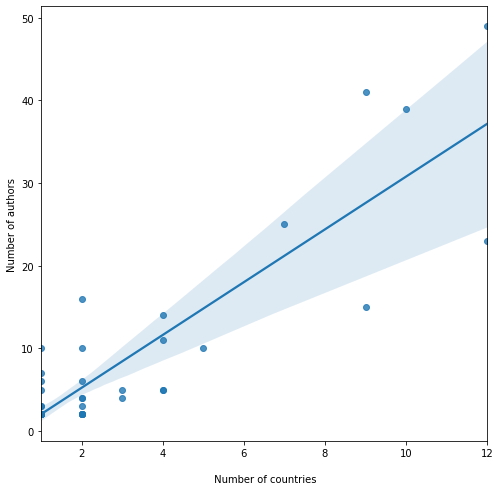

In [37]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(countries_summary['N_countries'], countries_summary['N_authors'])
ax.set(xlabel='\n Number of countries', 
       ylabel='Number of authors')

In [38]:
[get_highest_eigen_in_module(x) for x in countries_summary[countries_summary.N_authors>=10].index.values]

Number of nodes:  15  in module  0 

Modularity Sorted by Eigenvector Centrality:
Maximilian Schwarz |  0.08084146449549443  |  AU
Fritz Josef [Friedrich] Gusenleitner |  0.01635333120213761  |  AU
Karl Mazzucco |  0.012015231943082728  |  AU
Esther Ockermüller |  0.011209840199713222  |  AU
Jan Smit |  0.011209840199713222  |  NL
Klaus Standfuss |  0.00984467927893155  |  GA
Timofey Victorovich Levchenko |  0.00984467927893155  |  RS
Erwin Scheuchl |  0.006744632643034571  |  GM
Ardeshir Ariana |  0.0062729046007867755  |  JA
Gerald Hölzler |  0.0014633793955146125  |  AU



Number of nodes:  10  in module  1 

Modularity Sorted by Eigenvector Centrality:
Mariano Lucia |  0.03892360298128937  |  AR
Alberto H. Abrahamovich |  0.019653001273778548  |  AR
Leopoldo J. Alvarez |  0.014641130915029601  |  AR
Silvana P. Durante |  0.00724861898028626  |  AR
Arturo Roig-Alsina |  0.0009532832070745064  |  AR
Juan Pablo Torretta |  0.00011607369668554397  |  AR
Luis A. Compagnucci |  0.0001160

[None, None, None, None, None, None, None, None, None, None, None, None]